In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
from scipy.signal import savgol_filter
import seaborn as sns
import ast
sns.set()

# Trajectories (obs, actions, penalty)

In [2]:
!ls ../data/a3c

In [3]:
!ls ../results/2_new_NN_architecture/4_results_report/0_air/standby_0

gpu_10	gpu_15	gpu_5  res  res_2


In [37]:
path = "../results/2_new_NN_architecture/4_results_report/1_immersion/delta_0.5/"
#path = "../data/"
COLUMN_NAMES = ["util_0", "power_0", "it_0", "cool_0",
                "util_1", "power_1", "it_1", "cool_1",
                "util_2", "power_2", "it_2", "cool_2",
                "action", "penalty"]
df = pd.read_csv(path+'a3c/a3c_trajectories_0.csv',
                 delimiter=";",
                 names=COLUMN_NAMES,

                )
df.head()

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,action,penalty
0,-2.949946,-3.785157,-5.148372,-3.785157,-2.949946,-3.785157,-5.148372,-3.785157,-2.949946,-3.785157,-5.148372,-3.785157,edc_0,False
1,-2.949946,-3.785157,-5.148372,-3.785157,-2.949946,-3.785157,-5.148372,-3.785157,-2.949946,-3.785157,-5.148372,-3.785157,edc_0,False
2,-2.949946,-3.007163,-4.370378,-3.785157,-2.949946,-3.007163,-4.370378,-3.785157,-2.949946,-3.007163,-4.370378,-3.785157,edc_0,False
3,-2.725288,-2.945436,-4.308651,-3.785157,-2.949946,-3.007163,-4.370378,-3.785157,-2.949946,-3.007163,-4.370378,-3.785157,edc_0,False
4,-2.500629,-2.869078,-4.232293,-3.785157,-2.949946,-3.007163,-4.370378,-3.785157,-2.949946,-3.007163,-4.370378,-3.785157,edc_0,False


In [38]:
gpus_per_edc = 10
scale_dict = {"normalization": {gpus_per_edc: {"power": (58*gpus_per_edc, 80*gpus_per_edc),
                                                        "util": (0, 100*gpus_per_edc),
                                                        "dist": (299.58, 2186.21)
                                                        },
                                        },
               "standarization": {5: {"power": (361.19, 25.89),
                                      "util": (268.08, 111.47),
                                      "dist": (1088.39, 540.25)
                                      },
                                  10: {"power": (944.16, 183.39),
                                       "util": (656.54, 222.56),
                                       "dist": (1088.39, 540.25)
                                       },
                                 }
                      }
scale_mode = "standarization"
scale_factor = gpus_per_edc


def inverse_scale_data(scale_data):
        if scale_mode == "normalization":
            return scale_data * (scale_pair[1] - scale_pair[0]) + scale_pair[0]
        if scale_mode == "standarization":
            return scale_data * scale_pair[1] + scale_pair[0]
        return scale_data
        
scaled_col = COLUMN_NAMES[:-2]

scaled_df = df.copy()
scale_pair = scale_dict[scale_mode][scale_factor]["util"]
scaled_df[scaled_col[0::4]] = scaled_df[scaled_col[0::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[1::4]] = scaled_df[scaled_col[1::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[2::4]] = scaled_df[scaled_col[2::4]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[3::4]] = scaled_df[scaled_col[3::4]].apply(inverse_scale_data)

for i in range(3):
    scaled_df["pue_"+str(i)] = scaled_df["power_"+str(i)] / scaled_df["it_"+str(i)]
    
#scaled_df["total_pue"] = (scaled_df["pue_0"] + scaled_df["pue_1"] + scaled_df["pue_2"])/3

scaled_df["total_power"] = scaled_df["power_0"] + scaled_df["power_1"] + scaled_df["power_2"]
scaled_df["total_it"] = scaled_df["it_0"] + scaled_df["it_1"] + scaled_df["it_2"]
scaled_df["total_cool"] = scaled_df["cool_0"] + scaled_df["cool_1"] + scaled_df["cool_2"]
scaled_df["total_util"] = scaled_df["util_0"] + scaled_df["util_1"] + scaled_df["util_2"]
scaled_df["total_pue"] = scaled_df["total_power"] / scaled_df["total_it"]


scaled_df = scaled_df[~scaled_df.isin([np.nan, np.inf, -np.inf]).any(1)]

scaled_df.describe()

,util_0,power_0,it_0,cool_0,util_1,power_1,it_1,cool_1,util_2,power_2,it_2,cool_2,pue_0,pue_1,pue_2,total_power,total_it,total_cool,total_util,total_pue
count,2.358000e+03,2358.000000,2.358000e+03,2358.000000,2.358000e+03,2358.000000,2.358000e+03,2358.000000,2.358000e+03,2358.000000,2.358000e+03,2.358000e+03,2.358000e+03,2.358000e+03,2.358000e+03,2358.000000,2358.000000,2358.000000,2358.000000,2.358000e+03
mean,9.006043e+02,1041.290632,9.179297e+02,123.360919,1.900869e+02,536.857142,3.693005e+02,167.556611,3.516609e-07,392.555438,1.425554e+02,2.500000e+02,3.454996e+05,3.455000e+05,3.455012e+05,1970.703213,1429.785685,540.917530,1090.691264,3.454999e+05
std,1.183180e+02,39.892716,4.493440e+01,5.851505,5.550959e+01,44.293360,6.418321e+01,20.523994,0.000000e+00,4.154352,4.154352e+00,5.685548e-14,1.186072e+07,1.186072e+07,1.186072e+07,70.687125,91.317368,22.484109,139.367431,1.186072e+07
min,3.516609e-07,250.000000,6.137338e-07,122.863154,3.516609e-07,250.000000,6.137338e-07,156.180103,3.516609e-07,250.000000,6.137338e-07,2.500000e+02,1.131059e+00,1.377092e+00,2.752216e+00,750.000001,0.000002,529.043257,0.000001,1.354038e+00
25%,8.750000e+02,1037.999627,9.148858e+02,122.893692,1.750000e+02,504.301146,3.301700e+02,157.389484,3.516609e-07,392.676453,1.426765e+02,2.500000e+02,1.131524e+00,1.386547e+00,2.752216e+00,1951.997401,1406.709626,530.387313,1050.000000,1.358937e+00
50%,9.250000e+02,1051.161440,9.282031e+02,122.958308,2.000000e+02,562.016788,4.040801e+02,157.936695,3.516609e-07,392.676453,1.426765e+02,2.500000e+02,1.132469e+00,1.390855e+00,2.752216e+00,1997.861137,1465.555764,531.009578,1125.000000,1.362125e+00
75%,9.750000e+02,1057.273170,9.343795e+02,123.113862,2.250000e+02,564.557750,4.071683e+02,174.131163,3.516609e-07,392.676453,1.426765e+02,2.500000e+02,1.134567e+00,1.527399e+00,2.752216e+00,2008.909954,1478.047852,547.024855,1175.000000,1.388726e+00
max,1.000000e+03,1060.330805,9.374677e+02,250.000000,2.500000e+02,570.349994,4.141699e+02,250.000000,3.516609e-07,392.676453,1.426765e+02,2.500000e+02,4.073427e+08,4.073427e+08,4.073427e+08,2023.357252,1494.313996,750.000001,1250.000000,4.073427e+08


In [36]:
scaled_df_1 = scaled_df[~scaled_df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [32]:
scaled_df_2 = scaled_df[~scaled_df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [39]:
scaled_df_3 = scaled_df[~scaled_df.isin([np.nan, np.inf, -np.inf]).any(1)]

# Pump Comparison

In [40]:
df_results = pd.DataFrame()

df_results["1-power"] = scaled_df_1.describe()["total_power"]
df_results["2-power"] = scaled_df_2.describe()["total_power"]
df_results["3-power"] = scaled_df_3.describe()["total_power"]
#df_results["saving-power"] = (1 - df_results["e-power"]/df_results["c-power"])*100

df_results["1-pue"] = scaled_df_1.iloc[10:].describe()["total_pue"]
df_results["2-pue"] = scaled_df_2.iloc[10:].describe()["total_pue"]
df_results["3-pue"] = scaled_df_3.iloc[10:].describe()["total_pue"]
#df_results["saving-pue"] = ( df_results["e-pue"]/df_results["c-pue"]-1)*100

df_results

,1-power,2-power,3-power,1-pue,2-pue,3-pue
count,2232.000000,2322.000000,2358.000000,2222.000000,2312.000000,2348.000000
mean,1937.613762,1912.659838,1970.703213,1.355612,1.348731,1.378855
std,143.530497,76.185510,70.687125,0.016275,0.029518,0.037281
min,750.000001,750.000001,750.000001,1.323793,1.326992,1.354038
25%,1867.259213,1893.891010,1951.997401,1.347189,1.330020,1.358937
50%,1982.043715,1913.267229,1997.861137,1.352770,1.336868,1.361981
75%,2035.742915,1961.652216,2008.909954,1.368306,1.356750,1.388726
max,2102.965617,1982.942443,2023.357252,1.449195,1.523599,1.605697


In [45]:
for col in ["power", "pue"]:
    print(col)
    for stat in ["mean", "max"]:
        print(stat)
        stat_values = [df_results.loc[stat,str(i)+"-"+col] for i in range(1,4)]
        min_stat = min(stat_values)
        for i in range(3):
            print(i, round((stat_values[i]/min_stat - 1)*100,3))

power
mean
0 1.305
1 0.0
2 3.035
max
0 6.053
1 0.0
2 2.038
pue
mean
0 0.51
1 0.0
2 2.233
max
0 0.0
1 5.134
2 10.799


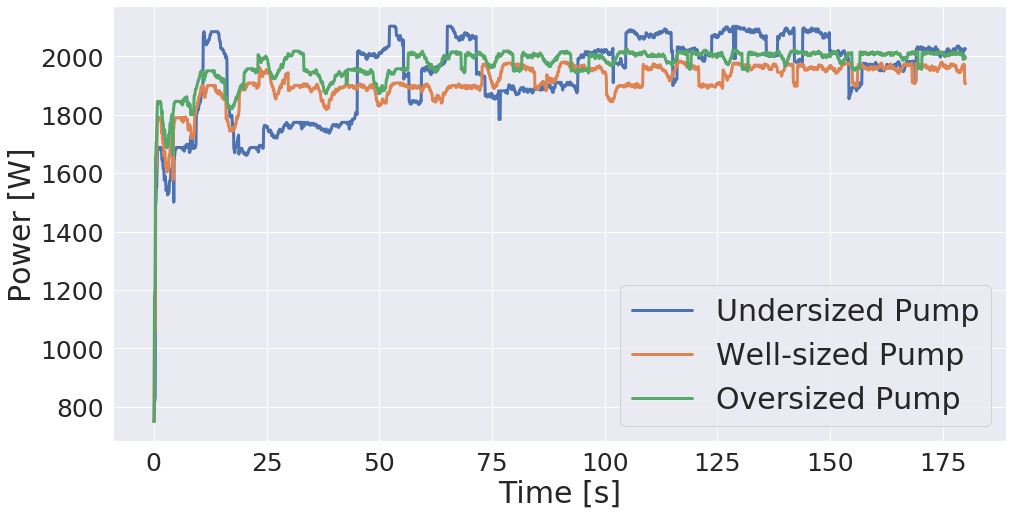

In [43]:
sim_time = 180
time_1 = np.linspace(0, sim_time, len(scaled_df_1))
time_2 = np.linspace(0, sim_time, len(scaled_df_2))
time_3 = np.linspace(0, sim_time, len(scaled_df_3))


plt.figure(figsize=(16,8))
plt.plot(time_1, scaled_df_1["total_power"], label="Undersized Pump", linewidth=3)
plt.plot(time_2, scaled_df_2["total_power"], label="Well-sized Pump", linewidth=3)
plt.plot(time_3, scaled_df_3["total_power"], label="Oversized Pump", linewidth=3)
plt.ylabel("Power [W]", fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.show()

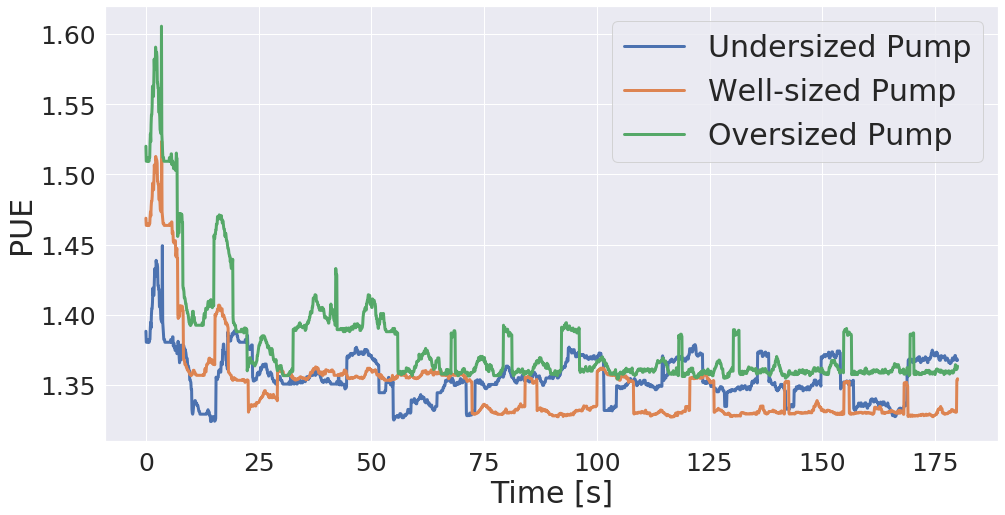

In [44]:
sim_time = 180
off=10
time_1 = np.linspace(0, sim_time, len(scaled_df_1)-off)
time_2 = np.linspace(0, sim_time, len(scaled_df_2)-off)
time_3 = np.linspace(0, sim_time, len(scaled_df_3)-off)


plt.figure(figsize=(16,8))
plt.plot(time_1, scaled_df_1["total_pue"][off:], label="Undersized Pump", linewidth=3)
plt.plot(time_2, scaled_df_2["total_pue"][off:], label="Well-sized Pump", linewidth=3)
plt.plot(time_3, scaled_df_3["total_pue"][off:], label="Oversized Pump", linewidth=3)
plt.ylabel("PUE", fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.show()